# Creating the Bathymetry

This notebook demostrates the creation of the grid of the project's model.

## Import Packages and Modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install --quiet netcdf4 xarray "dask[complete]" ipympl

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.8 MB/s eta 0:00:00


Making plots interactive to preprocess the model bathymetry manually.

In [2]:
from google.colab import output
output.enable_custom_widget_manager()

%matplotlib widget

In [3]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

sys.path.append('/content/drive/MyDrive')
from eccoseas.downscale import bathymetry as edb

## Bathymetry Source File

To generate the bathymetry for the model, first obtain a subset of the global GEBCO bathymetry grid from [GEBCO Gridded Bathymetry Data](https://www.gebco.net/data_and_products/gridded_bathymetry_data/)

For the project's model, it will be using the global coverage grids. Due to the size of the file (7 GB) it will be read in chunks to reduce the system ram and increase speed.

### Interpolating Bathymetry onto the Model Domain
Next, I use an interpolation function to interpolate the GEBCO Bathymetry onto the domain of my model.

In [4]:
# read in the bathymetry grid
file_path = '/content/drive/MyDrive/GEBCO_2024.nc'
ds  = xr.open_dataset(file_path, chunks={'lon': 1000, 'lat': 1000, 'elevation': 1000})
gebco_lon = ds.variables['lon'].values # longitude
gebco_lat = ds.variables['lat'].values # latitude
gebco_bathy = ds.variables['elevation'].values # depth

# create a meshgrid of the lon and lat
gebco_lon_mg, gebco_lat_mg = np.meshgrid(gebco_lon, gebco_lat)

In [5]:
# recreate the model grid - see previous notebook on creating the model grid for details
del_x = 1
del_y = 1
xg_origin = -180
yg_origin = -90
n_rows = 180
n_cols = 360

xc = np.arange(xg_origin + del_x / 2, xg_origin + n_cols * del_x, del_x)
yc = np.arange(yg_origin + del_y / 2, yg_origin + n_rows * del_y, del_y)
xc_mg, yc_mg = np.meshgrid(xc, yc)
print('Double check shape:', np.shape(xc),np.shape(yc))

Double check shape: (360,) (180,)


Using the `xarray` built-in `interp` function instead of `scipy.interpolate.griddata` because of the size.

In [6]:
# interpolate the gebco data onto the model grid
model_bathy = ds.elevation.interp(lon=xc, lat=yc, method='nearest').compute()
ds.close()

In [7]:
# set points on land to 0
model_bathy = model_bathy.values
model_bathy[model_bathy > 0] = 0

## Visualizing the Bathymetry Grid

Plots of the bathymetry and the source data will be used to compare. This will validate for the desired output. With the size of the data source, downsampling is necessary to reduce load on the memory and increase processing speed.

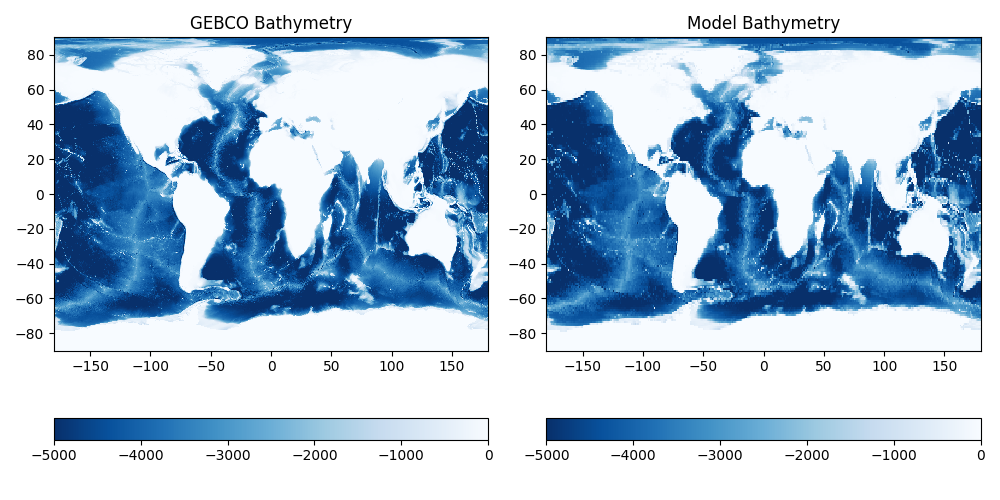

In [8]:
# Downsample by taking every 2nd point
downsample_factor = 2
gebco_bathy_downsampled = gebco_bathy[::downsample_factor, ::downsample_factor]
gebco_lon_downsampled = gebco_lon_mg[::downsample_factor, ::downsample_factor]
gebco_lat_downsampled = gebco_lat_mg[::downsample_factor, ::downsample_factor]

# Create lists for subplots
titles = ['GEBCO Bathymetry', 'Model Bathymetry']
lons = [gebco_lon_downsampled, xc_mg]
lats = [gebco_lat_downsampled, yc_mg]
baths = [gebco_bathy_downsampled, model_bathy]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
axs = [ax1, ax2]

for index, (ax, title, lon, lat, bath) in enumerate(zip(axs, titles, lons, lats, baths)):
  c = ax.pcolormesh(lon, lat, bath, vmin=-5000, vmax=0, cmap='Blues_r')
  fig.colorbar(c, ax=ax, orientation='horizontal')
  ax.set_title(title)

plt.tight_layout()
plt.show()

### Checking for isolated regions
One potential problem that can be encountered in ocean models occurs with isolated regions

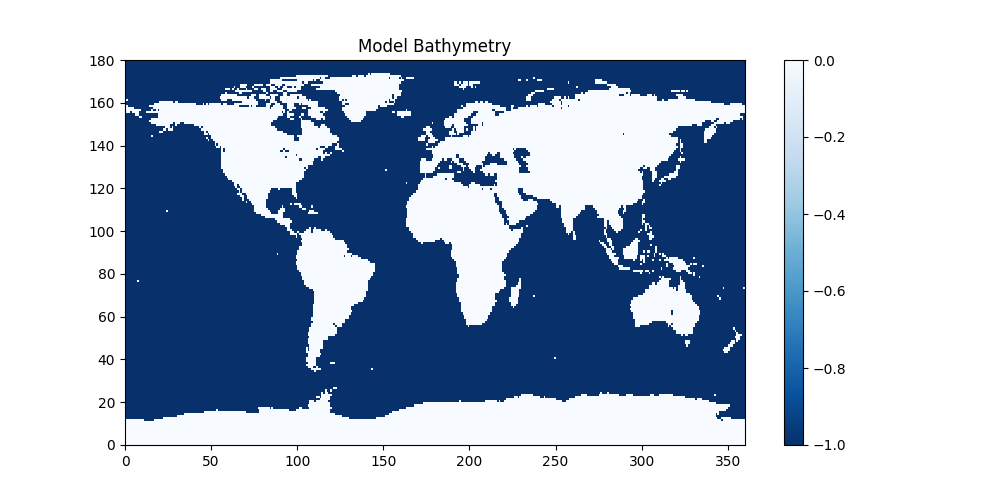

In [9]:
plt.figure(figsize=(10,5))

c = plt.pcolormesh(model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(c)

plt.title('Model Bathymetry')
plt.show()

There are several isolated regions throughout Earth.

Fortunately, Dr. Mike Wood has written a tool to fill in these unconnected regions. His [eccoseas](https://github.com/mhwood/eccoseas) repository to access a tool related to this process.

With the tools imported, we can now use the `fill_unconnected_model_regions` to fill in these regions.

In [10]:
model_bathy = edb.fill_unconnected_model_regions(model_bathy, central_wet_row=150, central_wet_col=150)

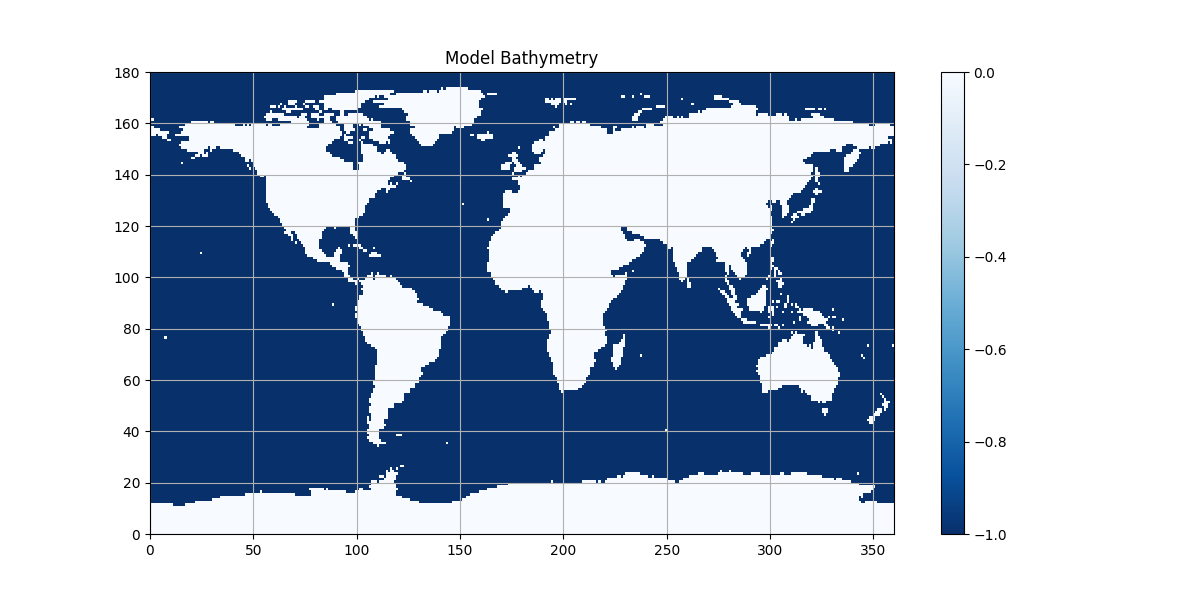

In [11]:
plt.figure(figsize=(12,6))

C = plt.pcolormesh(model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.grid()
plt.title('Model Bathymetry')

plt.show()

## Preprocessing and Smoothing

Another potential problem that can be encountered in ocean models occurs in regions where there is shallow bathymetry in enclosed bays. In these regions, there can be fast currents and strong dynamics. The following will fill in bays, remove countries, and smooth out the edges.

In [12]:
# Fill Antartica
model_bathy_filled = np.copy(model_bathy)
model_bathy_filled[11:17, :53] = 0
model_bathy_filled[15:19, 54:85] = 0
model_bathy_filled[17:26, 103:117] = 0
model_bathy_filled[14:27, 117:123] = 0
model_bathy_filled[20:24, 194:230] = 0
model_bathy_filled[12:19, 343:361] = 0

# Fill PNW
model_bathy_filled[147:151, 24:29] = 0
model_bathy_filled[150:151, 32:34] = 0
model_bathy_filled[145:146, 48:49] = 0
model_bathy_filled[152:155, 14:19] = 0
model_bathy_filled[156:159, 12:16] = 0
model_bathy_filled[160:161, 28:29] = 0
model_bathy_filled[139:140, 55:56] = 0

# Fill Canada
model_bathy_filled[157, 92:103] = 0
model_bathy_filled[158:170, 55:100] = 0
model_bathy_filled[159, 41:49] = 0
model_bathy_filled[141:157, 85:118] = 0
model_bathy_filled[157:160, 100:108] = 0
model_bathy_filled[157:160, 100:108] = 0
model_bathy_filled[166:172, 102:119] = 0

# Fill Baja California
model_bathy_filled[113:118, 68:74] = 0

# Fill Middle East
model_bathy_filled[100:107, 223:235] = 0
model_bathy_filled[113:120, 228:240] = 0

# Remove Caribean
model_bathy_filled[108:113, 96:112] = -1

# Remove Sri Lanka
model_bathy_filled[95:100, 260:262] = -1

# Remove South East Asia Islands
model_bathy_filled[79:115, 300:336] = -1

# Remove Japan
model_bathy_filled[121:131, 310:322] = -1
model_bathy_filled[132:143, 321:325] = -1

# Remove Islands in Long 0 - 50
model_bathy_filled[142:144, 47:49] = -1
model_bathy_filled[76:77, 7:8] = -1
model_bathy_filled[109:110, 24:25] = -1
model_bathy_filled[144:145, 15:16] = -1
model_bathy_filled[161:162, 0:2] = -1
model_bathy_filled[153:157, 8:10] = -1
model_bathy_filled[146:147, 20:22] = -1

# Remove Islands in Long 50 - 100
model_bathy_filled[89:90, 88:89] = -1

# Remove Islands in Long 100 - 150
model_bathy_filled[38:39, 119:122] = -1
model_bathy_filled[35:36, 143:144] = -1
model_bathy_filled[132:138, 114:120] = -1
model_bathy_filled[137:141, 122:127] = -1

# Remove Islands in Long 150 - 200
model_bathy_filled[128:129, 151:152] = -1
model_bathy_filled[122:123, 163:164] = -1
model_bathy_filled[138:149, 170:178] = -1
model_bathy_filled[139:151, 178:182] = -1
model_bathy_filled[153:157, 155:166] = -1
model_bathy_filled[171:172, 163:168] = -1
model_bathy_filled[166:170, 191:209] = -1

# Clean Up Long 200 - 250
model_bathy_filled[69:70, 237:238] = -1
model_bathy_filled[161:172, 228:249] = -1
model_bathy_filled[69:70, 237:238] = -1
model_bathy_filled[40:41, 249:250] = -1

# Clean up Long 250 - 300
model_bathy_filled[80:100, 275:301] = -1
model_bathy_filled[100:101, 278:279] = -1
model_bathy_filled[169:170, 257:258] = -1
model_bathy_filled[167:168, 262:263] = -1
model_bathy_filled[100:101, 299:301] = -1

# Clean up Long 300 - 350
model_bathy_filled[23:24, 342:343] = -1
model_bathy_filled[68:79, 333:348] = -1
model_bathy_filled[165:166, 317:327] = -1
model_bathy_filled[43:46, 347:351] = -1

# Clean up Long 350 - 360
model_bathy_filled[46:55, 350:358] = -1
model_bathy_filled[73:74, 359:361] = -1

# Smooth out the edges long 0 - 50
model_bathy_filled[154:156, 0:6] = 0
model_bathy_filled[147:148, 22:23] = -1

# Smooth out the edges long 50 - 100
model_bathy_filled[118:119, 65:66] = 0
model_bathy_filled[119:120, 89:90] = -1
model_bathy_filled[84:89, 99:100] = -1
model_bathy_filled[95:105, 96:103] = -1
model_bathy_filled[108:112, 89:93] = -1

# Smooth out the edges long 100 - 150
model_bathy_filled[36:55, 105:108] = -1
model_bathy_filled[58:60, 108:109] = -1
model_bathy_filled[34:45, 108:114] = -1
model_bathy_filled[62:63, 131:132] = -1
model_bathy_filled[91:92, 129:130] = -1
model_bathy_filled[99:102, 108:117] = 0
model_bathy_filled[161:166, 100:112] = 0
model_bathy_filled[158:164, 124:128] = 0
model_bathy_filled[157:159, 147:148] = 0
model_bathy_filled[172:174, 134:143] = 0

# Smooth out long 150 - 200
model_bathy_filled[55:56, 199:200] = -1
model_bathy_filled[163:173, 159:162] = -1
model_bathy_filled[94:95, 172:189] = -1
model_bathy_filled[95:97, 180:185] = 0
model_bathy_filled[111:112, 163:164] = -1
model_bathy_filled[127:134, 171:175] = -1
model_bathy_filled[136:139, 178:179] = -1
model_bathy_filled[145:154, 185:191] = -1
model_bathy_filled[158:159, 195:196] = -1

# Smooth out long 200 - 250
model_bathy_filled[155:161, 203:249] = 0
model_bathy_filled[67:68, 215:216] = -1
model_bathy_filled[74:80, 220:221] = -1
model_bathy_filled[162:163, 253:261] = 0
model_bathy_filled[22:23, 243:244] = -1

# Smooth out long 250 - 300
model_bathy_filled[20:21, 254:256] = 0
model_bathy_filled[111:112, 252:253] = 0
model_bathy_filled[106:107, 274:275] = -1
model_bathy_filled[101:105, 278:280] = -1
model_bathy_filled[164:165, 265:266] = -1
model_bathy_filled[167:171, 273:286] = -1
model_bathy_filled[108:112, 289:291] = -1
model_bathy_filled[163:165, 293:294] = 0
model_bathy_filled[127:130, 298:300] = 0
model_bathy_filled[23:24, 268:292] = 0
model_bathy_filled[24:25, 276:281] = -1
model_bathy_filled[64:65, 293:294] = 0

# Smooth out long 300 - 350
model_bathy_filled[126:130, 300:306] = 0
model_bathy_filled[23:24, 305:307] = -1
model_bathy_filled[21:22, 331:332] = 0
model_bathy_filled[46:49, 325:328] = -1
model_bathy_filled[55:56, 316:317] = 0
model_bathy_filled[51:52, 324:325] = 0
model_bathy_filled[72:74, 316:321] = 0
model_bathy_filled[75:76, 308:309] = 0
model_bathy_filled[78:79, 310:313] = -1
model_bathy_filled[118:119, 301:302] = -1
model_bathy_filled[139:140, 320:321] = -1
model_bathy_filled[143:146, 316:318] = 0
model_bathy_filled[149:150, 329:332] = 0
model_bathy_filled[149:152, 339:342] = 0
model_bathy_filled[147:151, 338:339] = 0
model_bathy_filled[151:152, 337:339] = 0
model_bathy_filled[150:151, 348:349] = 0
model_bathy_filled[149:150, 343:344] = 0
model_bathy_filled[161:164, 306:321] = 0
model_bathy_filled[163:164, 299:303] = 0
model_bathy_filled[77:79, 322:323] = -1

# Smooth out long 350 - 360
model_bathy_filled[152:154, 357:359] = -1
model_bathy_filled[159:160, 351:358] = -1

In [17]:
from scipy.ndimage import distance_transform_edt

# Assume model_bathy_filled is your filled bathymetry grid
model_bathy_filled = np.array(model_bathy_filled)  # Convert to NumPy array if not already

# Step 1: Identify mask of cells with -1 and valid ocean depths
mask_invalid = model_bathy_filled == -1           # Mask of invalid cells (-1)
mask_valid = model_bathy_filled < -1               # Mask of valid ocean cells (depth < -1)

# Step 2: Use distance transform to find nearest valid ocean cells
# Distance transform returns the distance to the nearest True cell
distances, nearest_indices = distance_transform_edt(
    ~mask_valid, return_indices=True
)

# Step 3: Use nearest valid indices to fill -1 cells
nearest_depths = model_bathy_filled[
    tuple(nearest_indices[i] for i in range(mask_invalid.ndim))  # Nearest ocean indices
]

# Replace -1 values with interpolated ocean depths
model_bathy_filled[mask_invalid] = nearest_depths[mask_invalid]

print("All -1 values have been replaced with nearby ocean depths.")

All -1 values have been replaced with nearby ocean depths.


Then, plot the filled bathymetry to ensure it looks as expected

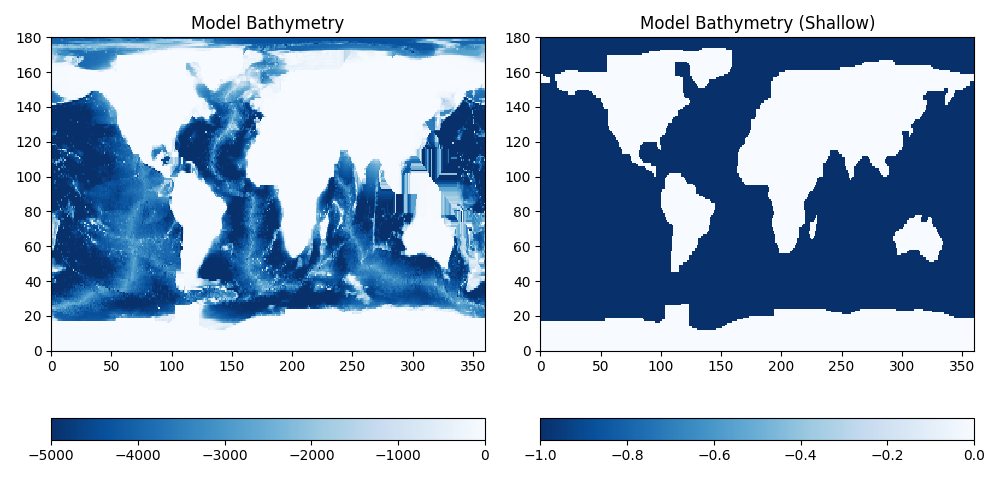

In [18]:
# List for subplot loop
vmins = [-5000, -1]
vmaxs = [0, 0]
titles = ['Model Bathymetry', 'Model Bathymetry (Shallow)']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
axs = [ax1, ax2]

for index, (ax, vmin, vmax, title) in enumerate(zip(axs, vmins, vmaxs, titles)):
  c = ax.pcolormesh(model_bathy_filled, vmin=vmin, vmax=vmax, cmap='Blues_r')
  fig.colorbar(c, ax=ax, orientation='horizontal')
  ax.set_title(title)

plt.tight_layout()
plt.show()

In [19]:
output_file = 'global_bathymetry.bin'
model_bathy_filled.ravel('C').astype('>f4').tofile(output_file)

This will be implemented into the model by editing the `PARM05` dataset of the `data` file as follows:
```
 &PARM05
 bathyFile = 'global_bathymetry.bin,
 &
```